# Test the pre-trained Keras U-Net model (prototype of cell segger model) on my dataset

The Keras U-Net model was adapted from Ammar Alhaj Ali's work in Sartorius-Cell Instance Segmentation Kaggle competetion and trained with the kaggle dataset, which contains 606 phase contrast microscopy images of several types of neuronal cells.

## Configure the Python environment

### load required modules

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import json
import cv2
import random

import tensorflow as tf
from tensorflow.keras.layers import concatenate

import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import Callback, ModelCheckpoint
from keras.models import load_model

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from google.colab import drive
from sklearn.model_selection import train_test_split

### mount google drive

In [ ]:
GD_PATH = '/content/drive'

if os.path.exists(GD_PATH) :
  print ('Google drive has mounted.')
else :
  drive.mount(GD_PATH)

MYDRIVE_PATH = os.path.join(GD_PATH, 'MyDrive')
# Path to cell images
IMAGE_PATH = os.path.join(MYDRIVE_PATH, 'cellimages', 'cell_images')
# Path to the pre-trained model
MODEL_PATH = os.path.join(MYDRIVE_PATH, 'cellimages', 'sartorius', 'unet_model_5.h5')

Mounted at /content/drive


### general variables

In [ ]:
N_CHANNEL = 3
BATCH_SIZE = 8
HEIGHT = 256
WIDTH = 256
N_CLASSES = 3
RANDOM_STATE = 2023

### some functions

In [ ]:
def rle_decode(mask_rle, dimension, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(dimension[0] * dimension[1], dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(dimension)


def build_masks(labels, dimension):
    '''Usually mask image'''

    mask = np.zeros(dimension, dtype=np.float32)
    for label in labels :
        _mask = rle_decode(label, dimension, color=1)
        mask = np.maximum(mask, _mask)
    return mask


def rle2maskResize(rle):
    # CONVERT RLE TO MASK
    if (len(rle)==0):
        return np.zeros((256,256) ,dtype=np.uint8)

    height= 520
    width = 704
    mask= np.zeros( width*height ,dtype=np.uint8)

    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]-1
    lengths = array[1::2]
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1

    return mask.reshape( (height,width), order='F' )[::2,::2]

## Data pipeline

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    '''Generates data for Keras'''
    def __init__(self, list_IDs, df, mode='fit', dim=(HEIGHT, WIDTH),
                 base_path=IMAGE_PATH, batch_size=BATCH_SIZE,
                 n_channels=N_CHANNEL, n_classes=N_CLASSES,
                 random_state=RANDOM_STATE, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state

        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]

        X = self.__generate_X(list_IDs_batch)

        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            return X, y

        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)

    def __generate_X(self, list_IDs_batch):
        '''Retrieve image'''
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        # Get image
        for i, ID in enumerate(list_IDs_batch):
            image_df = self.df[self.df['name'] == ID]
            img_path = f"{self.base_path}/{image_df.iloc[0,5]}"
            img = self.__load_grayscale(img_path)
            # Store samples
            X[i,] = img
        return X

    def __generate_y(self, list_IDs_batch):
        '''Restore image label'''
        # Initialization
        y = np.empty((self.batch_size, *self.dim, self.n_channels), dtype=np.float32)
        # Get annotations
        for i, ID in enumerate(list_IDs_batch):
            image_df = self.df[self.df['name'] == ID]
            original_dims = (image_df.iloc[0,3], image_df.iloc[0,2])
            rles = image_df['label'].values
            masks = build_masks(rles, original_dims)
            masks = cv2.resize(masks, self.dim)
            masks = np.expand_dims(masks, axis=-1)
            y[i, ] = masks
        return y

    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        # resize image
        img = cv2.resize(img, self.dim, interpolation=cv2.INTER_AREA)
        # normalize
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)
        return img

    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.
        return img

## Load dataset csvfile

In [ ]:
df = pd.read_csv(os.path.join(MYDRIVE_PATH, 'cellimages', 'all_cells.csv'))
# Remove square brackets in column 'label'
df['label'] = df['label'].map(lambda x: x[1:-1])
# Only keep the image name in column 'image_path'
df['image_path'] = df['image_path'].map(lambda x: os.path.basename(x))

print (df.shape)
df.head()

(8596, 9)


,name,label,width,height,cell_type,image_path,bit_depth,image_format,channels
0,A9 p10f,185014 2 185456 11 185905 13 1863...,450,450,drosophila melanogaster Kc167 cells,A9 p10f.tif,"(8, 8, 8)",tif,3
1,A9 p10f,183689 4 184136 8 184584 11 1850...,450,450,drosophila melanogaster Kc167 cells,A9 p10f.tif,"(8, 8, 8)",tif,3
2,A9 p10f,174174 4 174623 8 175072 11 1755...,450,450,drosophila melanogaster Kc167 cells,A9 p10f.tif,"(8, 8, 8)",tif,3
3,A9 p10f,167446 8 167894 12 168343 16 1687...,450,450,drosophila melanogaster Kc167 cells,A9 p10f.tif,"(8, 8, 8)",tif,3
4,A9 p10f,163887 1 164333 12 164781 15 1652...,450,450,drosophila melanogaster Kc167 cells,A9 p10f.tif,"(8, 8, 8)",tif,3


In [ ]:
ID_LIST = list(df['name'].unique())

print (f'The number of images of this dataset: {len(ID_LIST)}')

The number of images of this dataset: 136


In [ ]:
# Randomly take out 16 images for test and the remaining 120 for training.
test_set_IDs = random.sample(ID_LIST, 16)
train_set_IDs = [id for id in ID_LIST if id not in test_set_IDs]

print (f'Traing dataset has {len(train_set_IDs)} images.')
print (f'Test dataset has {len(test_set_IDs)} images.')

Traing dataset has 120 images.
Test dataset has 16 images.


In [ ]:
train_IDs, validation_IDs = train_test_split(train_set_IDs, test_size=0.2, random_state=RANDOM_STATE)

train_gen = DataGenerator(
    train_IDs,
    df=df,
    batch_size=BATCH_SIZE,
    n_classes=N_CLASSES,
)

validation_gen = DataGenerator(
    validation_IDs,
    df=df,
    batch_size=BATCH_SIZE,
    n_classes=N_CLASSES,
)

testset_gen = DataGenerator(
    test_set_IDs,
    df=df,
    batch_size=1,
    n_classes=N_CLASSES,
    mode='predict',
)

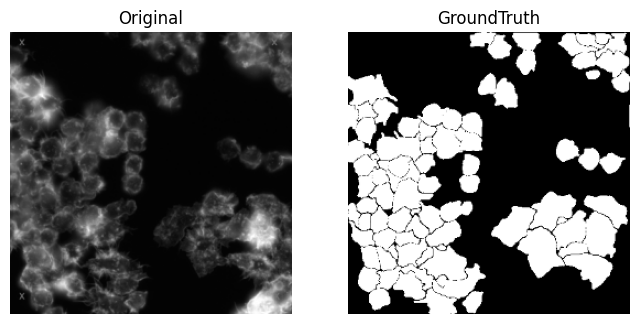

In [ ]:
# Visualize some images and their label
i = random.randint(0, len(train_gen))
j = random.randint(0, BATCH_SIZE)

images, labels = train_gen[i]
fig, axs = plt.subplots(1, 2, figsize=(8, 6))
axs[0].imshow(images[j])
axs[0].set_title('Original')
axs[0].axis('off')

axs[1].imshow(labels[j], cmap='gray')
axs[1].set_title('GroundTruth')
axs[1].axis('off')

plt.show()

## U-Net model

### Call for the dependencies for UNet model

In [ ]:
!pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 7.2 MB/s eta 0:00:00


In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-hfxto6yv
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models /tmp/pip-req-build-hfxto6yv
  Resolved https://github.com/qubvel/segmentation_models to commit e951c6747f75fa9e7240816d1c79dd2e66813123
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done


In [ ]:
# Model metrics
from keras import backend as K
from keras.losses import binary_crossentropy
import tensorflow as tf

class Metrics(object):

    def __init__(self, smooth: int = 1):
        self.smooth = smooth

    def dice_coef(self, y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + self.smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + self.smooth)

    def iou_coef(self, y_true, y_pred):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + self.smooth) / (union + self.smooth), axis=0)
        return iou

    def dice_loss(self, y_true, y_pred):
        smooth = 1.
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = y_true_f * y_pred_f
        score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        return 1. - score

    def bce_dice_loss(self, y_true, y_pred):
        return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * self.dice_loss(tf.cast(y_true, tf.float32), y_pred)

In [ ]:
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `tf.keras` framework.


'tf.keras'

In [ ]:
# Unet model
class UnetModel:

    def __init__(self, model_path, model_metrics):

        self.model_path = model_path
        self.model_metrics = model_metrics
        self.model = None

        self.load()

    def load(self):
        if self.model == None:

            try:
                self.model = tf.keras.models.load_model(
                    self.model_path,
                    custom_objects=None,
                    compile=False,
                    options=None
                    )

                self.model.compile(
                    optimizer='adam',
                    loss=self.model_metrics.bce_dice_loss,
                    metrics=[self.model_metrics.dice_coef, self.model_metrics.iou_coef, 'accuracy']
                )

            except:

                self.model = None

        else:

            pass

        return self

In [ ]:
# Call for the saved UNet model
def get_model():
    metrics = Metrics()
    model = UnetModel(model_path=MODEL_PATH, model_metrics=metrics).model
    return model

predictor = get_model()
predictor.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 128, 128, 32  128         ['stem_conv[0][0]']              
                                )                                                             

## Train the model

In [ ]:
from keras.callbacks import Callback, ModelCheckpoint

checkpoint_path = "training_4/cp-{epoch:04d}.ckpt"
checkpoint_path = os.path.join(MYDRIVE_PATH, 'cellimages', checkpoint_path)

EPOCHS = 50
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='auto'
)

history = predictor.fit(
    train_gen,
    validation_data=validation_gen,
    callbacks=[checkpoint],
    use_multiprocessing=False,
    workers=4,
    epochs=EPOCHS
)

Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 1.0719 - dice_coef: 0.3554 - iou_coef: 0.3352 - accuracy: 0.1614
Epoch 1: val_loss improved from inf to 1.49012, saving model to /content/drive/MyDrive/cellimages/training_4/cp-0001.ckpt
12/12 [==============================] - 97s 3s/step - loss: 1.0719 - dice_coef: 0.3554 - iou_coef: 0.3352 - accuracy: 0.1614 - val_loss: 1.4901 - val_dice_coef: 0.2678 - val_iou_coef: 0.1400 - val_accuracy: 0.2663
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 0.6153 - dice_coef: 0.4888 - iou_coef: 0.4110 - accuracy: 0.1972
Epoch 2: val_loss improved from 1.49012 to 0.84613, saving model to /content/drive/MyDrive/cellimages/training_4/cp-0002.ckpt
12/12 [==============================] - 9s 720ms/step - loss: 0.6153 - dice_coef: 0.4888 - iou_coef: 0.4110 - accuracy: 0.1972 - val_loss: 0.8461 - val_dice_coef: 0.2862 - val_iou_coef: 0.1896 - val_accuracy: 0.1706
Epoch 3/50
12/12 [==============================] - ET

In [ ]:
hist_df = pd.DataFrame(history.history)
hist_df.to_csv(os.path.join(MYDRIVE_PATH, 'cellimages', 'history_02.csv'))

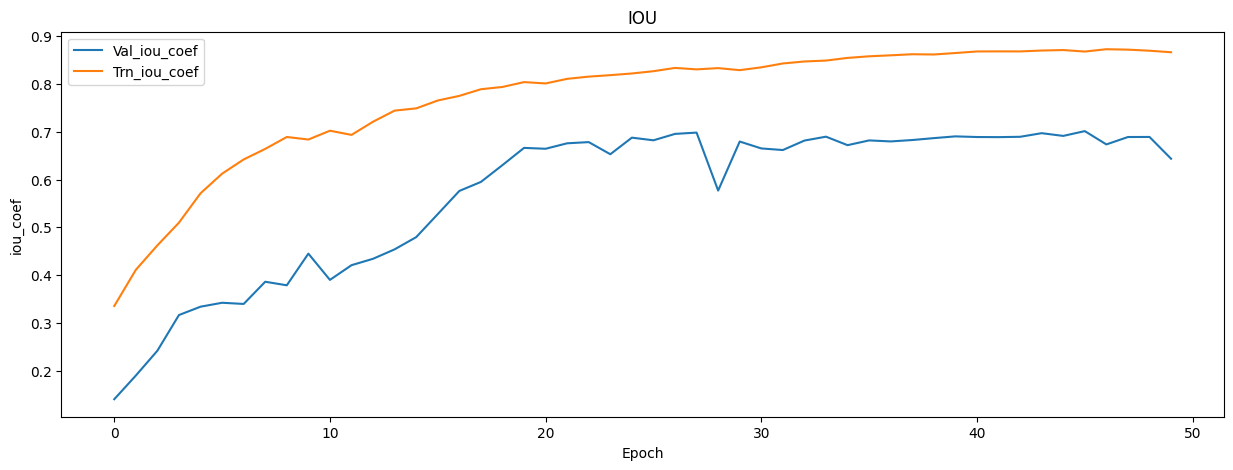

In [ ]:
# PLOT TRAINING
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_iou_coef'],label='Val_iou_coef')
plt.plot(range(history.epoch[-1]+1),history.history['iou_coef'],label='Trn_iou_coef')
plt.title('IOU'); plt.xlabel('Epoch'); plt.ylabel('iou_coef');plt.legend();
plt.show()

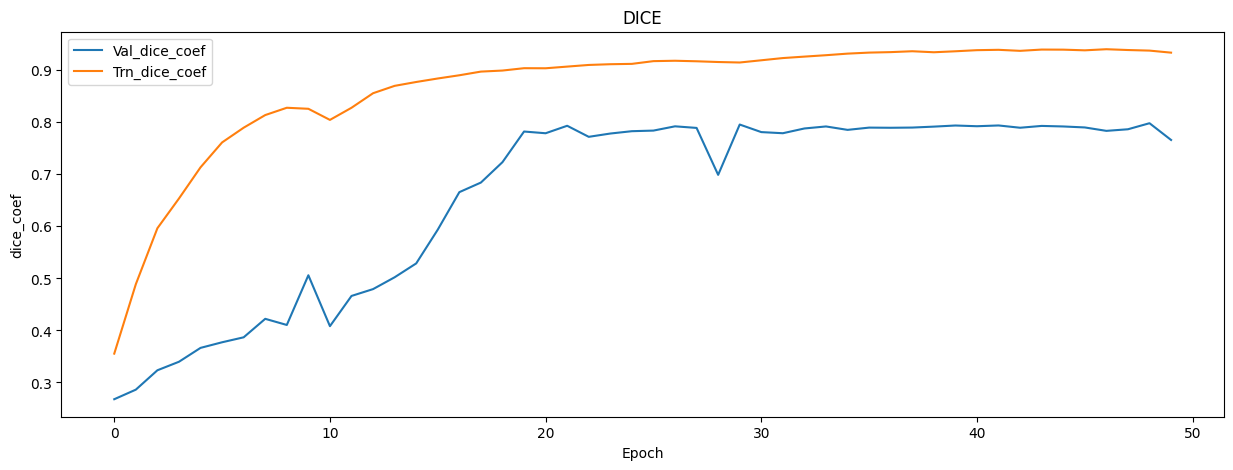

In [ ]:
# PLOT TRAINING
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_dice_coef'],label='Val_dice_coef')
plt.plot(range(history.epoch[-1]+1),history.history['dice_coef'],label='Trn_dice_coef')
plt.title('DICE'); plt.xlabel('Epoch'); plt.ylabel('dice_coef');plt.legend();
plt.show()

In [ ]:
# Save the model
predictor.save(os.path.join(MYDRIVE_PATH, 'cellimages', 'unet_model_8.h5'))

## Test the model

1/1 [==============================] - 0s 72ms/step


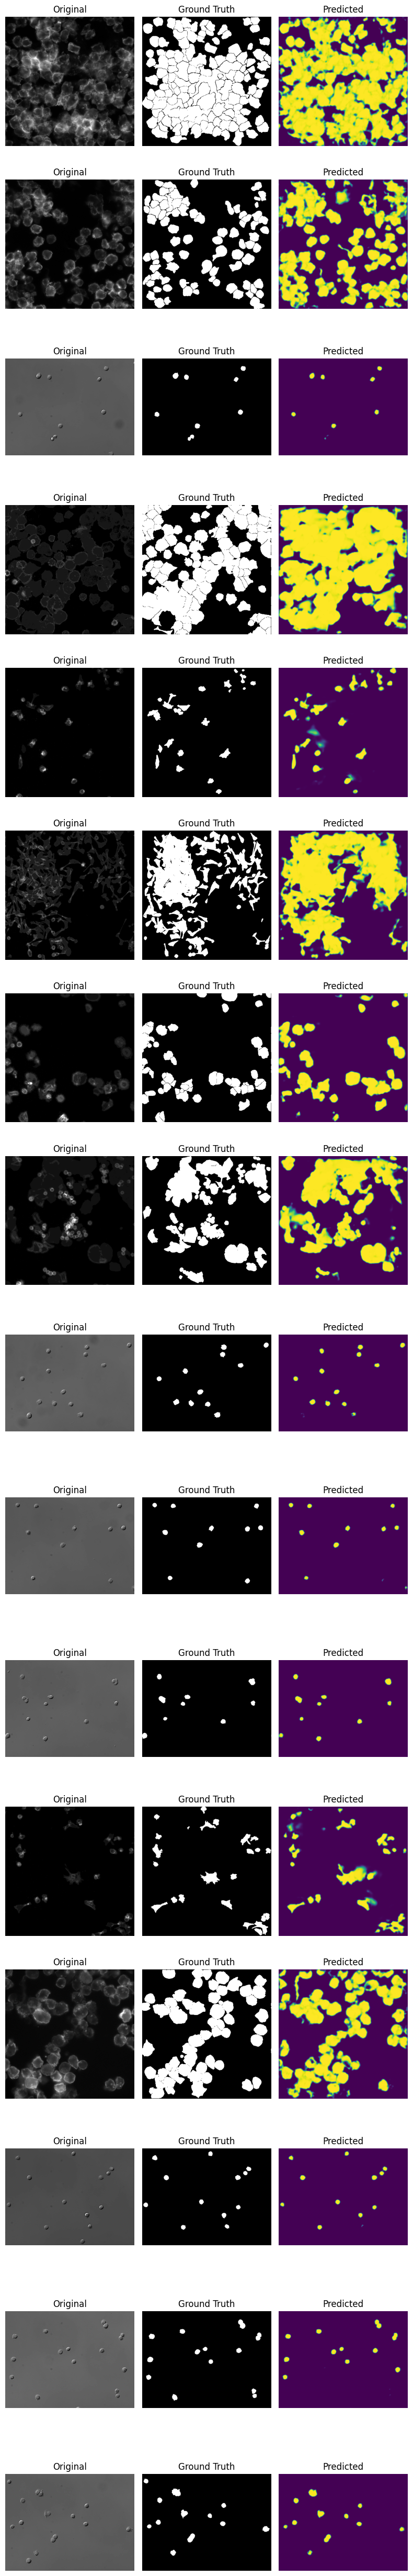

In [49]:
# Compute IOU and DICE, and plot results

fig, axs = plt.subplots(len(test_set_IDs), 3, figsize=(8,50))

for i, name in enumerate(test_set_IDs):

    image_df = df[df['name'] == name]

    # Retrieve the original image
    original_img = cv2.imread(f'{IMAGE_PATH}/{image_df.iloc[0, 5]}', cv2.IMREAD_GRAYSCALE)

    # Retrieve the ground truth
    rles = image_df['label'].values
    ground_truth = build_masks(rles, original_img.shape)

    # Model prediction
    predicted = predictor.predict(
        DataGenerator(
            [name],
            df=df,
            batch_size=1,
            n_classes=N_CLASSES,
            mode='predict',
        )
    )

    # Resize the predicted to original size
    predicted = np.uint8(predicted[0,:,:,:] * 255)
    predicted = cv2.cvtColor(predicted, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(predicted, (original_img.shape[1], original_img.shape[0]), interpolation=cv2.INTER_AREA)

    axs[i, 0].imshow(original_img, cmap='gray')
    axs[i, 0].set_title('Original')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(ground_truth, cmap='gray')
    axs[i, 1].set_title('Ground Truth')
    axs[i, 1].axis('off')

    axs[i, 2].imshow(resized)
    axs[i, 2].set_title('Predicted')
    axs[i, 2].axis('off')

plt.tight_layout()
plt.show()